<a href="https://colab.research.google.com/github/ArmandoLp/AprendizajeMaquina-Profundo/blob/main/Tarea2_Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab
# https://github.com/TylerYep/torch-summary
!pip install torch-summary
# https://zarr.readthedocs.io/en/stable/
!pip install zarr


Importamos toda la utiliría necesaria tomando como base el notebook de la arqitectura RNN vista en clase

In [ ]:
# funciones aleatorias
import random
# sistema de archivos
import os
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchsummary import summary

# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

Definimos la creación del dataset

In [ ]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://drive.google.com/uc?id=1cpJTE5qoMoSswymGdPzvsX9k_gPQuPwQ&export=download',
            download_root=self.root,
            filename='ucf11.zarr.tar.gz',
        )

Creamos un datast y vemos las dimensiones

In [ ]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


Realizamos la partición para entrenamiento y prueba

In [ ]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### Data loaders
Creamos el cargador de datos para entrenamiento y prueba

In [ ]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=4
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=4
)

Verificamos el tamño y tipo de un ejemplo

In [ ]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


### Modelo
Implementamos la arquitectura RNN la cual tendrá la modificación de ser bidirecional, por lo que hay que cambiar la entrada de la lineal también

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super(RNN, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        #modificación para la tarea
        self.rnn = nn.GRU(input_size=input_size, hidden_size=32,
                          num_layers=1, batch_first=True, bidirectional=True)
        self.cls = nn.Linear(64, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.permute(0, 2, 1)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.permute(0, 2, 1)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # take last output step. Quizz 1
        #print("Shape after rnnGRU", x.shape)
        x = x[:, -1, :]
        #print("Sahpe after taking last layer",x.shape)
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x

In [ ]:
modelRNN = RNN().eval()
modelRNN(torch.zeros(2, 10, 1024)).shape

torch.Size([2, 11])

### Resumen de la GRU
Vemos que parámetros tenemos, el total es de 205899, ahora trataremos de llegar a una cantidad similar con una arquitectura CNN

In [ ]:
summary(modelRNN, (10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm1d: 1-1                       [-1, 1024, 10]            2,048
├─GRU: 1-2                               [-1, 10, 64]              203,136
├─Linear: 1-3                            [-1, 11]                  715
Total params: 205,899
Trainable params: 205,899
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.04
Forward/backward pass size (MB): 0.08
Params size (MB): 0.79
Estimated Total Size (MB): 0.91

### Modelo CNN
Para lograr la cantidad de parámetros, después de algunas pruebas, lo que hice fue dejar solo una capa conv1d con una salida de 72 filtros, los demás parámetros quedaron igual, y se modifica la entrada a la lineal

In [ ]:
# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        #self.num_feats = 4 * 14 * 14
        
        # definición de bloques conv
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        self.cnn = nn.Sequential(
            # bloque conv1
            # [N, 10, 28, 28] => [N, 16, 28, 28]
            nn.Conv1d(in_channels=10, out_channels=72,
                      kernel_size=3, padding=1),
            # [N, 16, 28, 28] => [N, 32, 28, 28]          
            #nn.Conv1d(in_channels=16, out_channels=32,
            #          kernel_size=3, padding=1),
            
            # [N, 32, 28, 28] => [N, 64, 28, 28] 
            #nn.Conv1d(in_channels=32, out_channels=64,
            #          kernel_size=3, padding=1),
            #[N, 64, 28, 28] 
            nn.ReLU(),
            #[N, 64, 28, 28]  => [N, 64, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [N, 64, 14, 14] => [N, 64x14x14]=12544
        self.flatten = nn.Flatten()

        # [N, 4x14x14] => [N, 1]
        self.cls = nn.Sequential(
            nn.Linear(18432, 11))
    
    # metodo para inferencia
    def forward(self, x):
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        #print("Shape x before cnn", x.shape)
        x = self.cnn(x)
        #print("shape x after cnn", x.shape)
        # [N, 8, 7, 7] => [N, 4x14x14]
        x = self.flatten(x)
        #print("shape x after flatten", x.shape)
        # [N, 4x14x14] => [N, 10]
        x = self.cls(x)
        return x


In [ ]:
modelCNN = CNN().eval()
modelCNN(torch.zeros(2, 10, 1024)).shape

torch.Size([2, 11])

In [ ]:
summary(modelCNN, (10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 36, 512]             --
|    └─Conv1d: 2-1                       [-1, 72, 1024]            2,232
|    └─ReLU: 2-2                         [-1, 72, 1024]            --
|    └─MaxPool2d: 2-3                    [-1, 36, 512]             --
├─Flatten: 1-2                           [-1, 18432]               --
├─Sequential: 1-3                        [-1, 11]                  --
|    └─Linear: 2-4                       [-1, 11]                  202,763
Total params: 204,995
Trainable params: 204,995
Non-trainable params: 0
Total mult-adds (M): 2.62
Input size (MB): 0.04
Forward/backward pass size (MB): 0.56
Params size (MB): 0.78
Estimated Total Size (MB): 1.38

### Párametros en RNN=205899 vs CNN=204995

### RNN Entrenamiento

In [ ]:
# optimizador
opt = optim.Adam(modelRNN.parameters(), lr=1e-3)

# ciclo de entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
    modelRNN.train()
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = modelRNN(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        modelRNN.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = modelRNN(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

E 0 loss=219.43 acc=24.69
E 1 loss=205.15 acc=30.94
E 2 loss=196.38 acc=35.00
E 3 loss=187.75 acc=39.06
E 4 loss=182.33 acc=40.31
E 5 loss=179.75 acc=41.88
E 6 loss=176.21 acc=41.88
E 7 loss=173.96 acc=42.81
E 8 loss=173.73 acc=43.44
E 9 loss=170.91 acc=44.69
E10 loss=171.41 acc=46.25
E11 loss=171.26 acc=46.56
E12 loss=170.77 acc=48.44
E13 loss=171.54 acc=46.88
E14 loss=171.86 acc=47.19
E15 loss=172.98 acc=46.56
E16 loss=173.76 acc=47.19
E17 loss=176.80 acc=44.69
E18 loss=177.06 acc=47.50
E19 loss=178.67 acc=46.25
E20 loss=178.58 acc=46.25
E21 loss=180.74 acc=47.19
E22 loss=180.90 acc=46.88
E23 loss=181.45 acc=48.44
E24 loss=181.01 acc=46.25
E25 loss=181.06 acc=46.88
E26 loss=182.46 acc=46.25
E27 loss=183.76 acc=47.81
E28 loss=183.68 acc=47.19
E29 loss=183.96 acc=47.81
E30 loss=185.21 acc=49.06
E31 loss=187.07 acc=47.19
E32 loss=190.45 acc=46.25
E33 loss=188.90 acc=48.75
E34 loss=188.16 acc=49.38
E35 loss=189.10 acc=49.38
E36 loss=188.06 acc=47.81
E37 loss=189.46 acc=46.88
E38 loss=189

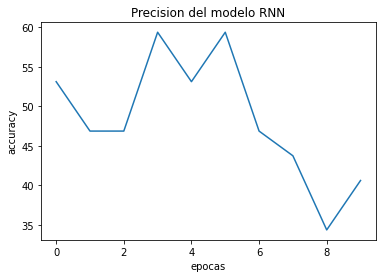

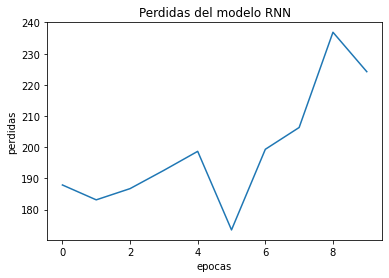

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accs)
plt.title('Precision del modelo RNN')
plt.ylabel('accuracy')
plt.xlabel('epocas')
plt.show()
# hacemos las grafica 2 perdidas
plt.plot(losses)
plt.title('Perdidas del modelo RNN')
plt.ylabel('perdidas')
plt.xlabel('epocas')

plt.show()

### CNN Entrenamiento

In [ ]:
# optimizador
opt = optim.Adam(modelCNN.parameters(), lr=1e-6)

# ciclo de entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
    modelCNN.train()
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = modelCNN(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        modelCNN.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = modelCNN(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

E 0 loss=204.83 acc=51.56
E 1 loss=204.83 acc=51.88
E 2 loss=204.85 acc=51.88
E 3 loss=204.83 acc=51.88
E 4 loss=204.87 acc=51.88
E 5 loss=204.88 acc=51.88
E 6 loss=204.90 acc=51.88
E 7 loss=204.91 acc=51.88
E 8 loss=204.91 acc=51.88
E 9 loss=204.93 acc=51.88
E10 loss=204.94 acc=51.88
E11 loss=204.92 acc=52.19
E12 loss=204.93 acc=52.19
E13 loss=204.95 acc=52.19
E14 loss=204.95 acc=51.88
E15 loss=204.98 acc=52.19
E16 loss=204.99 acc=52.19
E17 loss=204.97 acc=52.19
E18 loss=204.98 acc=52.19
E19 loss=205.01 acc=51.88
E20 loss=204.99 acc=52.19
E21 loss=205.02 acc=52.19
E22 loss=205.02 acc=52.19
E23 loss=205.05 acc=52.19
E24 loss=205.05 acc=52.19
E25 loss=205.07 acc=52.19
E26 loss=205.10 acc=52.19
E27 loss=205.08 acc=52.19
E28 loss=205.07 acc=52.19
E29 loss=205.09 acc=52.19
E30 loss=205.10 acc=52.19
E31 loss=205.07 acc=51.88
E32 loss=205.12 acc=52.19
E33 loss=205.13 acc=52.19
E34 loss=205.15 acc=52.19
E35 loss=205.12 acc=52.19
E36 loss=205.16 acc=52.19
E37 loss=205.15 acc=52.19
E38 loss=205

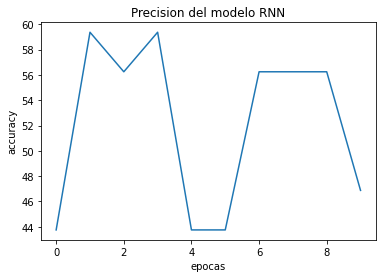

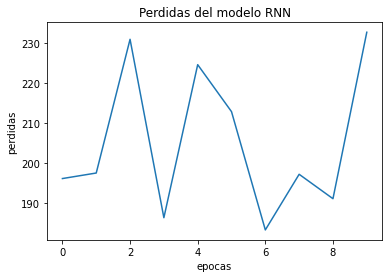

In [ ]:
plt.plot(accs)
plt.title('Precision del modelo RNN')
plt.ylabel('accuracy')
plt.xlabel('epocas')
plt.show()
# hacemos las grafica 2 perdidas
plt.plot(losses)
plt.title('Perdidas del modelo RNN')
plt.ylabel('perdidas')
plt.xlabel('epocas')

plt.show()

En conclusión, la arquitectura resultó ser más sensible, pero más precisa, al crear 72 filtros la red aprende mejor ciertas caracteristicas, pero al tener solo una capa lineal para clasificar toda la información obtenida es donde se pierde performance, a mi parecer, es por esto que el learning rate tuvo que ser más bajo ya que de otra forma era muy variante el resultado. Un solución con la cual mejorar la arquitectura CNN sería agregar más filtros, algunas capas de submuestreo y mejorar la capa de clasificación.

Por otro lado, la arquitectura GRU parece haber tenido un mejor comportamiento en clase, no siendo bidireccional, sin embargo debemos tener en cuenta que la RNN utilizada fue una arquitectura muy simple, por lo que no explotamos al 100 los beneficios de una GRU, sin embargo la desventaja es que los parámetros incrementan de una manera enorme, para mejorar este modelo yo agregaria más capas en la clasificación y jugar más con el tamaño de la GRU e incluso agregar más capas iguales a esta.